<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Copy_CNN_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [ ]:
!pip install tensorflow
!pip install keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os
import time
import sklearn
import numpy as np
import random as rn
import pandas as pd
start_time = time.time()
from numpy import loadtxt
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split


# load das libs
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import schedules, Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.models import Sequential
from keras.layers.embeddings import Embedding
#from keras import backend 
#dropoutpout, Activation
# from keras.layers import Embedding
# from keras.preprocessing import sequence
# from keras.layers import Dense, Dro
# from keras.layers import Conv1D, Flatten, MaxPooling1D
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# random state
sd = 5
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)
tf.random.set_seed(sd)

In [3]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [4]:
def pad(x, length=None):
    return pad_sequences(x, maxlen=length, padding='post')

In [5]:
def preprocess(x):
    preprocess_x, x_tk = tokenize(x)

    preprocess_x = pad(preprocess_x)

    return preprocess_x, x_tk

In [6]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [7]:
# Plot de Gráficos

def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('accuracy') 
  plt.xlabel('epoch')
  #plt.figure()
  plt.show()

In [8]:

def plot_loss(history, miny=None):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('loss') 
  plt.xlabel('epoch')
  plt.show()

# Carrega base

In [9]:
# Base1 Com StopWords
PATH_BASE1 = "/content/drive/MyDrive/TCC/dados/processadas/Base1_classificada.csv"

# Base2 Sem StopWords
PATH_BASE2 = "/content/drive/MyDrive/TCC/dados/processadas/Base2_classificada.csv"

# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

PATH_BASE_2_CLASSIFICADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

In [10]:
reviews = pd.read_csv(PATH_BASE_2_CLASSIFICADA, index_col=0)
reviews

,text,label
0,retwet bahia fazer sendo governada pt sei baia...,1
1,k imagine atitude mental negativa f idiota fec...,1
2,general heleno é bolsonaro rosna late late lat...,1
3,alan ser cara pau achar havendo ruptura nesse ...,1
4,canalhascomunistas caçarão chapa presidencialn...,1
...,...,...
10569,af hein amiga mandar outro número mail,0
10570,egoísmo é grande parte produto sociedade émile...,0
10571,abençoado novo linda querida obrigada carinho ...,0
10572,leva gente amorzinhos d,0


# Execução modelo

In [11]:
# pd.set_option('display.max_colwidth',1000)
texto = reviews['text']
texto

0        retwet bahia fazer sendo governada pt sei baia...
1        k imagine atitude mental negativa f idiota fec...
2        general heleno é bolsonaro rosna late late lat...
3        alan ser cara pau achar havendo ruptura nesse ...
4        canalhascomunistas caçarão chapa presidencialn...
                               ...                        
10569               af hein amiga mandar outro número mail
10570    egoísmo é grande parte produto sociedade émile...
10571    abençoado novo linda querida obrigada carinho ...
10572                              leva gente amorzinhos d
10573                                   k k ata meia sonsa
Name: text, Length: 10574, dtype: object

In [12]:
text_tokenized, text_tokenizer = tokenize(texto)

test_pad = pad(text_tokenized)

y = reviews['label']

preproc_texto, texto_tokenizer = preprocess(texto)
    
max_text_length = preproc_texto.shape[1]
text_vocab_size = len(texto_tokenizer.word_index)

worddx = texto_tokenizer.word_index

print("Max sentence length:", max_text_length)
print("Vocabulary size:", text_vocab_size)

Max sentence length: 55
Vocabulary size: 19043


In [13]:
# parametros:
tam_vocab = text_vocab_size # vocabulário do embedding
tam_max = max_text_length # 100
batchsize = 64  # 64
embedding_dimen = 300  # 50 ! 300
filtros = 250 #250
kernel_size = 2 # 3 | 2
hidden_dims = 100 # not used
epochs = 50
lr = 0.0006 # 0.00006
drp = 0.4   # coeficiente de dropout

X_train, X_test, y_train, y_test = train_test_split(test_pad, y, test_size=0.3)

In [20]:
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=10000,
    decay_rate=0.9)
# https://keras.io/api/optimizers/
#optimizer = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta") # 94% Embedding Treinado / 82% Embeddings FiltradoAdadelta
#optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name="SGD") # 59% Embedding Treinado / 60% Embeddings Filtrado
#optimizer = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=True,name="RMSprop")
#optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
#optimizer = Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
#optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
#optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") # 96% Embedding Treinado /
optimizer = Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.1, l2_regularization_strength=0.1, l2_shrinkage_regularization_strength=0.001, beta=0.0001, name="Ftrl")

start_time2 = time.time()
#wvec = KeyedVectors.load_word2vec_format('/content/cbow_s300.txt')
#wvec = KeyedVectors.load_word2vec_format("cbow_s50.txt")
#wvec = KeyedVectors.load_word2vec_format("skip_s50.txt")
print(); print("Time to load model: %.5s s.\n" % (time.time() - start_time2))


# gerando a matriz do embedding
# embedding_matrix = np.zeros((tam_vocab+1, embedding_dimen))
# for word, i in worddx.items():
#     if i>=tam_vocab:
#         continue
#     try:
#         embedding_vector = wvec[word]
#         embedding_matrix[i] = embedding_vector
#     except KeyError:
#         embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_dimen)

# del(wvec)

# defininindo a camada de embedding utilizando a matriz
# embedding_layer = Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
#                             output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
#                             weights=[MATRIZ_CBOW_300_BASE_2],
#                             input_length=tam_max,
#                             trainable=False)

#del(embedding_matrix)

#    embedding_vec = embeddings_index.get(word)
#    if embedding_vec is not None:
#        embedding_matrix[index] = embedding_vec

model = Sequential()
# primeira camada se trata do embedding. 
# model.add(embedding_layer)
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 


# input = numero de possiveis palavras, dimensão do espaço(complex!), e 137
#model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 

# camada convolucional
# filtros referentes ao output dessa camada,
# tamanho nucleo = 3, se tratando apenas de uma dimensão (conv1d)
# padding 'valid' = sem padding
# função de ativação = relu
model.add(Dropout(drp))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# camada convolucional                         'valid|same'
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# nivela o output para utilização na camada densa
model.add(Flatten())
#model.add(Dense(hidden_dims, activation='relu'))

# regularização por dropout
#model.add(Dropout(0.2))
#model.add(Dense(2, activation='sigmoid')) #FUNÇÃO VAGABUNDA
model.add(Dense(2, activation='softmax')) #FUNÇÃO VAGABUNDA

# calculo de loss adotado = binary_crossentropy/categorical_crossentropy
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

# tempo de execução total
print(); print("Tempo de execução: %.5s segundos.\n" % (time.time() - start_time))

# plot dos gráficos
plot_accuracy(history)
plot_loss(history)


Time to load model: 0.000 s.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 55, 300)           5712900   
                                                                 
 dropout_6 (Dropout)         (None, 55, 300)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 55, 250)           150250    
                                                                 
 conv1d_9 (Conv1D)           (None, 55, 250)           125250    
                                                                 
 dropout_7 (Dropout)         (None, 55, 250)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 27, 250)          0         
 1D)                                                             
                       

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


81/81 - 3s - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.4903 - 3s/epoch - 43ms/step
Epoch 2/50
81/81 - 2s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4903 - 2s/epoch - 28ms/step
Epoch 3/50
81/81 - 2s - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4903 - 2s/epoch - 28ms/step
Epoch 4/50
81/81 - 2s - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4903 - 2s/epoch - 28ms/step
Epoch 5/50
81/81 - 2s - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4903 - 2s/epoch - 28ms/step
Epoch 6/50
81/81 - 2s - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4903 - 2s/epoch - 28ms/step
Epoch 7/50
81/81 - 2s - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4903 - 2s/epoch - 28ms/step
Epoch 8/50
81/81 - 2s - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4903 - 2s/epoch - 28ms/step
Epoch 9/50
81/81 - 2s - loss: 0.6931 - accu

KeyboardInterrupt: ignored

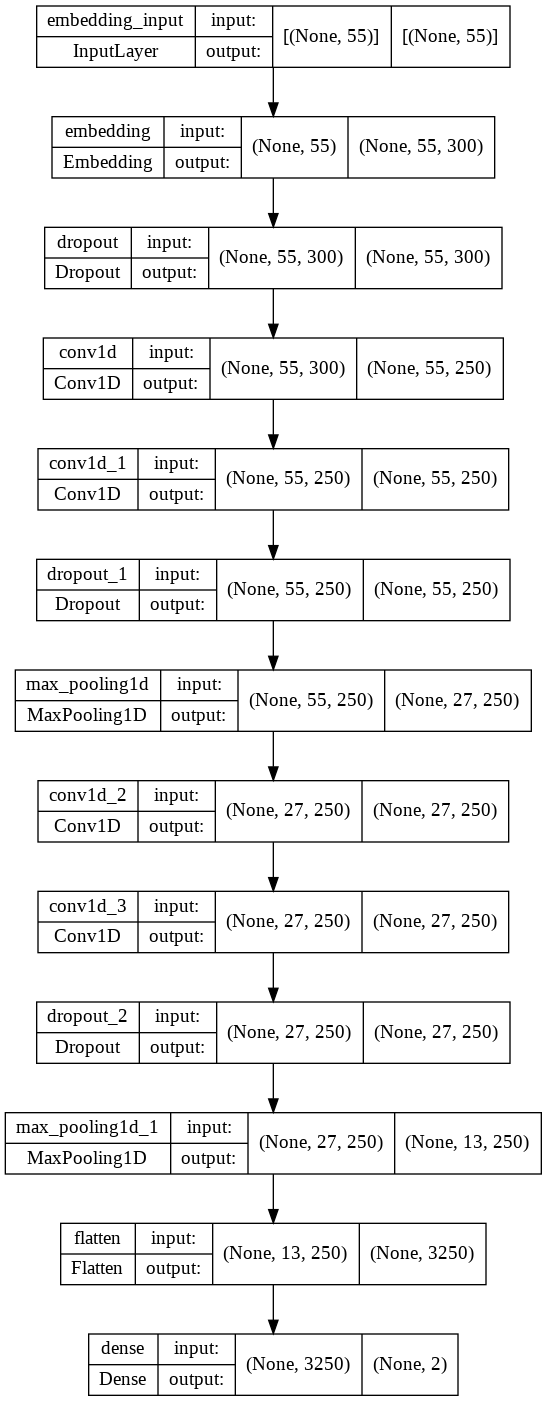

In [15]:
tf.keras.utils.plot_model(model, to_file='/meuarquivo.png', show_shapes=True)